# Systems perturbation of links in the biochemical cascade network

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Perturbation

In [4]:
import os 

### parameters 

notebook_name = 'combined_systems_perturbation_dyn'

## Generation of ground truth model 

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 500 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 

data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/combined_systems_perturbation_dyn_4_50/


### Generate ground truth model

In [5]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

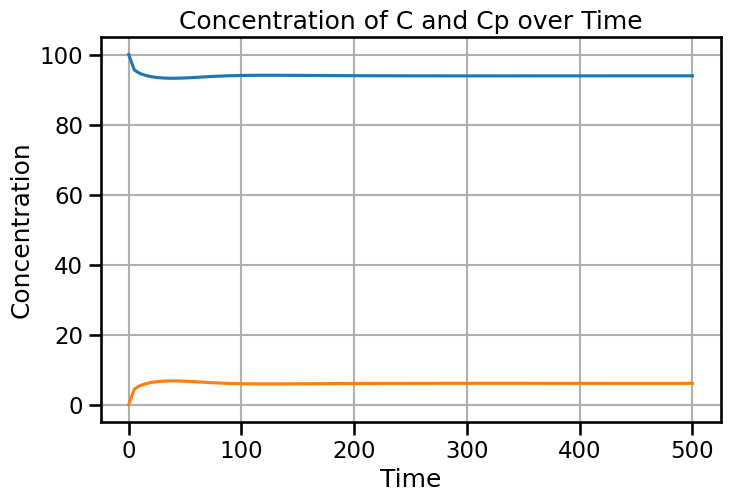

In [6]:
# === PLOT: Visible States Over Time ===

import seaborn as sns
sns.set_context('talk')
sns.axes_style('whitegrid')

# Initialize RoadRunner and simulate the model
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

# Define key observable states
visible_states = ['C', 'Cp']

# Plot the concentration of visible states over time
plt.figure(figsize=(8, 5))
for state in visible_states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of C and Cp over Time")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_01_C_Cp_time_course_ground_truth.png')
plt.show()

### Generate synthetic data

In [7]:
### Generate the synthetic data

feature_df = generate_feature_data(model_spec, runner, feature_generation_method, feature_generation_extra_params, feature_generation_size, seed=feature_generation_seed)
initial_values = get_model_initial_values(model_spec, runner)

target_df, time_course_data = generate_target_data(model_spec, runner, feature_df, initial_values)

### Generate suboptimal models (2 edge removed random)

In [8]:
n_sub = 10
suboptimal_models_2rm = []
suboptimal_models_spec_2rm = []

for i in range(n_sub):
    s_spec, s_model, _ = systematic_edge_pruning(model_spec, G0, 2, random_seed=i)
    suboptimal_models_spec_2rm.append(s_spec)
    suboptimal_models_2rm.append(s_model)

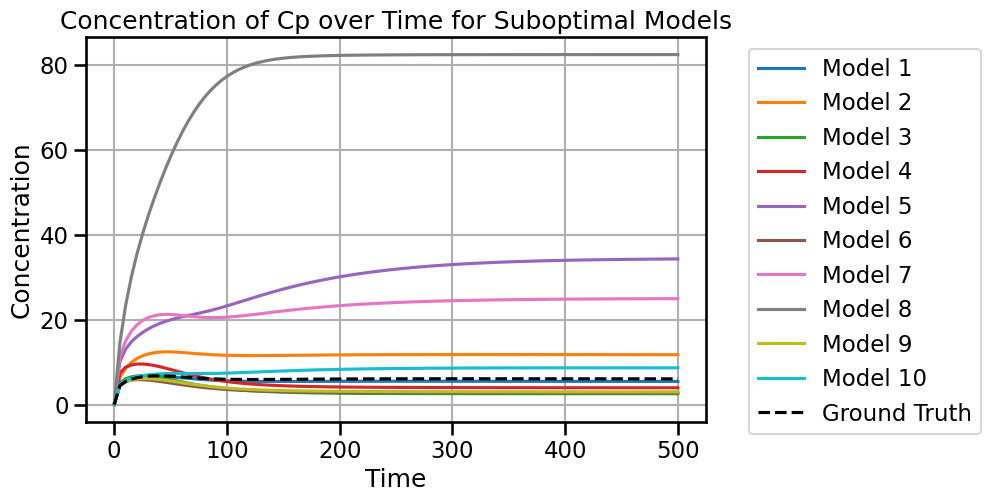

In [9]:
# Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
plt.figure(figsize=(8, 5))

for i, s_model in enumerate(suboptimal_models_2rm):
    runner = roadrunner.RoadRunner(s_model.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label=f"Model {i+1}")
    
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)
plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
    
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of Cp over Time for Suboptimal Models")
plt.grid(True)
# set the legend to be outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Generate suboptimal models (3 edge removed random)

In [10]:
n_sub = 10
suboptimal_models_3rm = []
suboptimal_models_spec_3rm = []

for i in range(n_sub):
    s_spec, s_model, _ = systematic_edge_pruning(model_spec, G0, 3, random_seed=i)
    suboptimal_models_spec_3rm.append(s_spec)
    suboptimal_models_3rm.append(s_model)

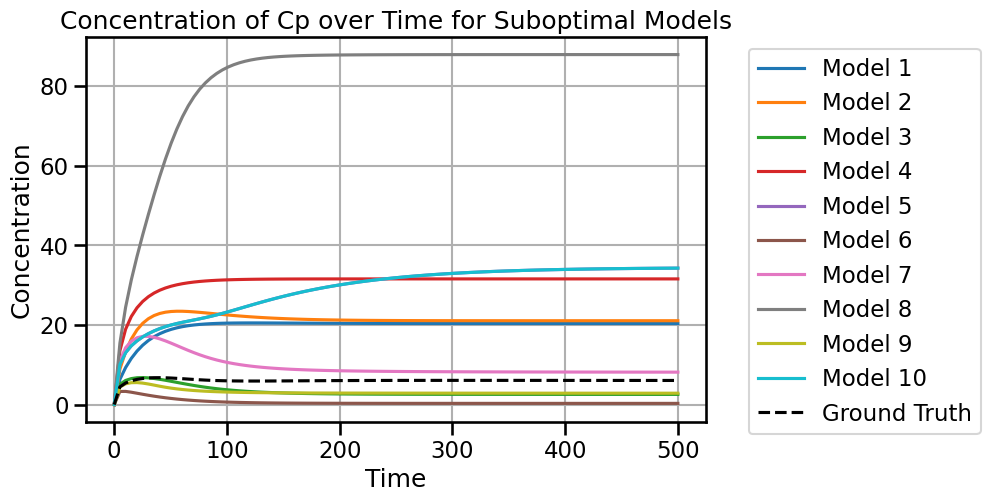

In [11]:
# Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
plt.figure(figsize=(8, 5))

for i, s_model in enumerate(suboptimal_models_3rm):
    runner = roadrunner.RoadRunner(s_model.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label=f"Model {i+1}")
    
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)
plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
    
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of Cp over Time for Suboptimal Models")
plt.grid(True)
# set the legend to be outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Generate timecourse data from ground truth model

In [12]:
# obtain the last time point for each phosphorylated species
all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
all_phos_species = [s+'p' for s in all_species]
all_time_course_data_G0 = generate_model_timecourse_data(model_spec, runner, feature_df, initial_values)
all_time_course_data_phos_G0 = all_time_course_data_G0[all_phos_species]

### Generate last time point feature from timecourse data for ground truth model

In [13]:
dynamic_feature_df_G0 = dynamic_features_method(all_time_course_data_G0, all_phos_species)

100%|██████████| 1000/1000 [00:13<00:00, 73.15it/s]


### Create different variations of the last time point feature

In [14]:
all_Ap_species = [s+'p' for s in model_spec.A_species]
all_Bp_species = [s+'p' for s in model_spec.B_species]

dynamic_feature_df_G0_Cless = dynamic_feature_df_G0.loc[:,~dynamic_feature_df_G0.columns.str.contains('Cp')]
dynamic_feature_df_G0_AOnly = dynamic_feature_df_G0.copy()
for Bp in all_Bp_species:
    dynamic_feature_df_G0_AOnly = dynamic_feature_df_G0_AOnly.loc[:,~dynamic_feature_df_G0_AOnly.columns.str.contains(Bp)]
dynamic_feature_df_G0_AOnly = dynamic_feature_df_G0_AOnly.loc[:,~dynamic_feature_df_G0_AOnly.columns.str.contains('Cp')]
dynamic_feature_df_G0_BOnly = dynamic_feature_df_G0.copy()
for Ap in all_Ap_species:
    dynamic_feature_df_G0_BOnly = dynamic_feature_df_G0_BOnly.loc[:,~dynamic_feature_df_G0_BOnly.columns.str.contains(Ap)]
dynamic_feature_df_G0_BOnly = dynamic_feature_df_G0_BOnly.loc[:,~dynamic_feature_df_G0_BOnly.columns.str.contains('Cp')]

In [ ]:
# combine Cless with original feature data

combined_data_Cless = pd.concat([feature_df, dynamic_feature_df_G0_Cless], axis=1)
combined_data_AOnly = pd.concat([feature_df, dynamic_feature_df_G0_AOnly], axis=1)
combined_data_BOnly = pd.concat([feature_df, dynamic_feature_df_G0_BOnly], axis=1)

### Perform machine learning on G0 last time point features and CLess last time point features

In [ ]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = [feature_df, dynamic_feature_df_G0, dynamic_feature_df_G0_Cless, dynamic_feature_df_G0_AOnly, dynamic_feature_df_G0_BOnly, combined_data_Cless, combined_data_AOnly, combined_data_BOnly]
all_features_desc = ['Mock Omics Data (A+B)', 'Dynamic Feat G0', 'Dynamic Feat No Cp', 'Dynamic Feat Ap Only', 'Dynamic Feat Bp Only', 'Combined Cless + Omics', 'Combined AOnly + Omics', 'Combined BOnly + Omics']
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in zipped_feature_data:
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,Mock Omics Data (A+B),9.765032,0.544332,0.738797,8.875073e-36
1,Linear Regression,Mock Omics Data (A+B),6.739859,0.675590,0.822899,1.683065e-50
2,Linear Regression,Mock Omics Data (A+B),8.048785,0.640917,0.800968,5.453817e-46
3,Linear Regression,Mock Omics Data (A+B),8.750939,0.630894,0.796698,3.545026e-45
4,Linear Regression,Mock Omics Data (A+B),6.078354,0.703370,0.843334,2.651691e-55
...,...,...,...,...,...,...
295,Neural Network,Combined Cless + Omics,0.786360,0.952189,0.977798,2.389909e-136
296,Neural Network,Combined Cless + Omics,0.742279,0.961416,0.981352,8.977874e-144
297,Neural Network,Combined Cless + Omics,0.639981,0.969372,0.984845,1.284976e-152
298,Neural Network,Combined Cless + Omics,0.911530,0.962237,0.982113,1.502238e-145


In [17]:
# save metric_df 
if save_figures: metric_df.to_pickle(experiment_folder+'metric_df.pkl')

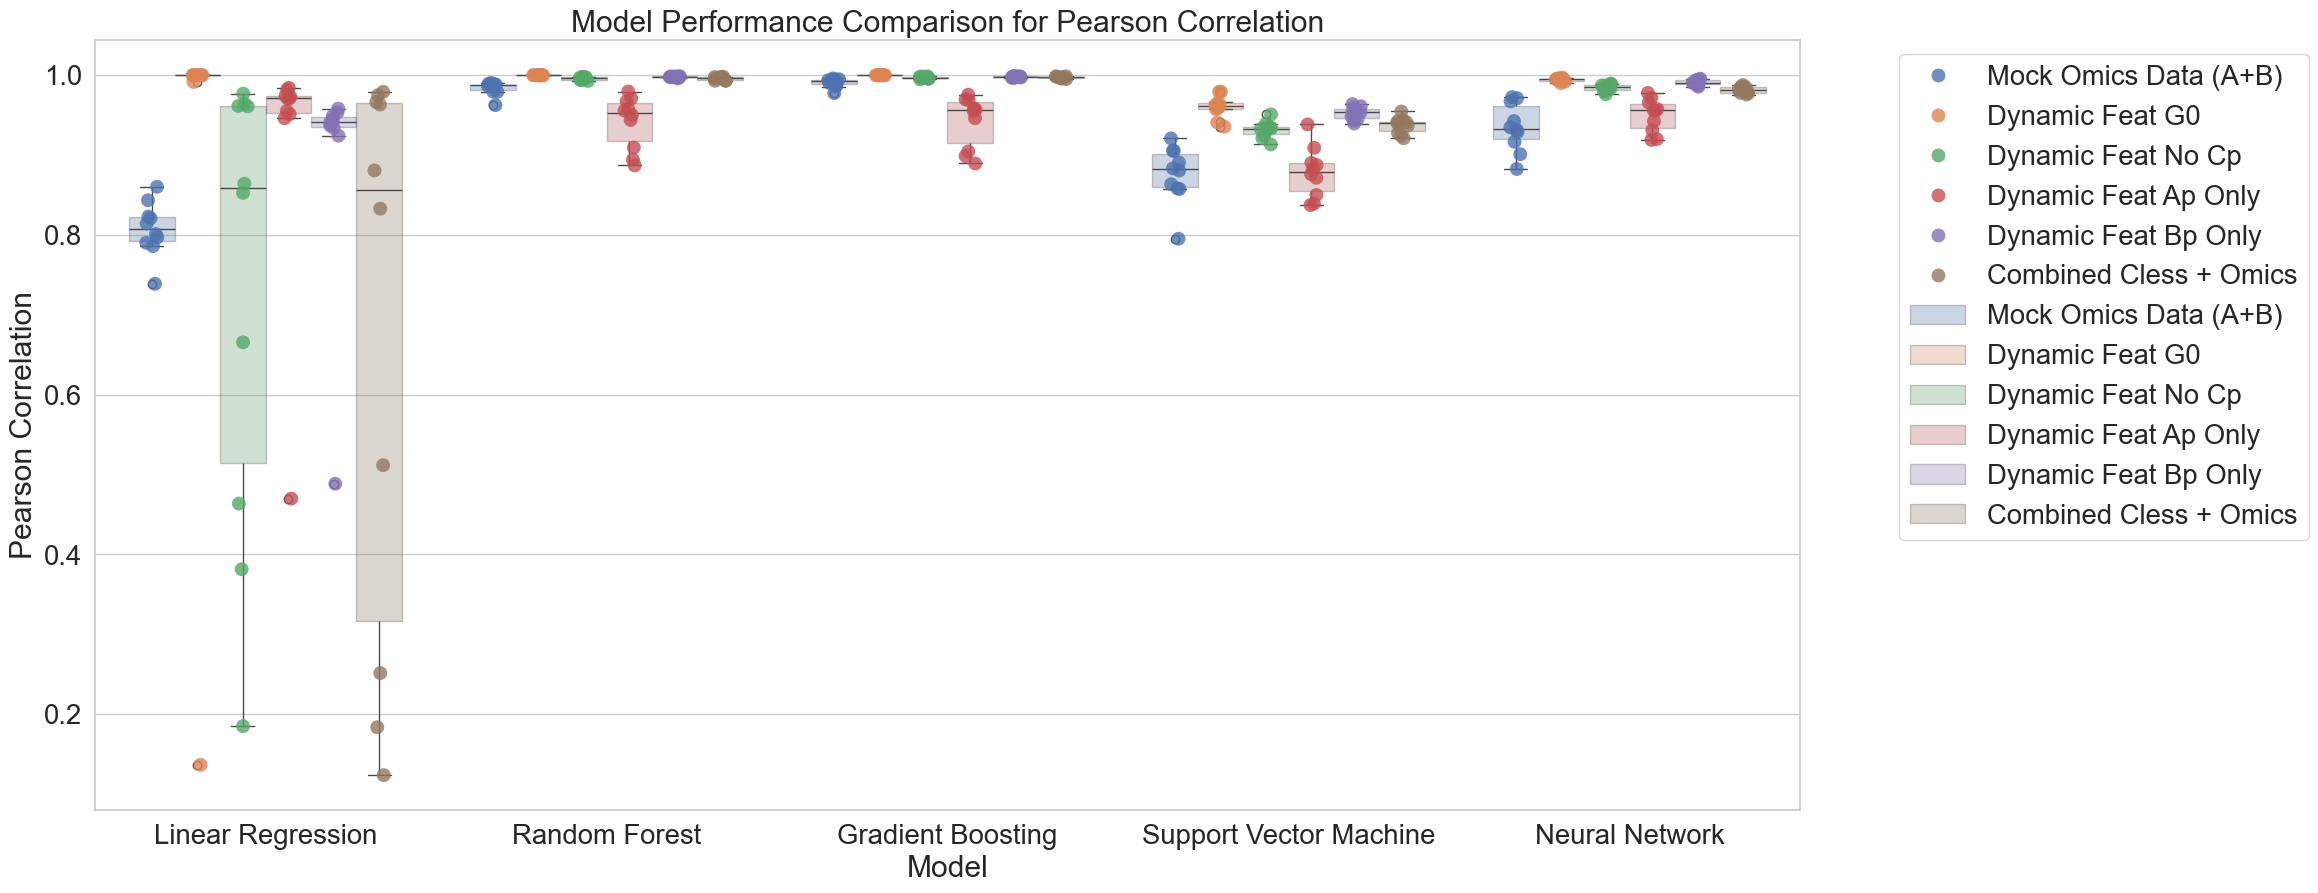

In [18]:
# visualise the performance of the models
# create box plots for each model type and feature data type, plot for pearson correlation

# load metric_df from data_path 
metric_df = pd.read_pickle(experiment_folder+'metric_df.pkl')

sns.set(rc={'figure.figsize':(22,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()